In [1]:
import sklearn
import re
import nltk
import csv
import random
import matplotlib.pyplot as plt
import seaborn as sns
import sklearn.metrics as metrics
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize
from nltk.stem import WordNetLemmatizer
from nltk.probability import FreqDist
from sklearn.feature_extraction.text import TfidfVectorizer, TfidfTransformer, CountVectorizer

import pandas as pd
import numpy as np
from sklearn.naive_bayes import MultinomialNB
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split, cross_val_score, KFold
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix

global Y, vector, df

df = pd.read_csv(r'C:\Users\melan\OneDrive\Documents\drugsTrain2.csv', 
                 names = ['Name', 'Condition', 'Review', 'Rating'])

df = df.drop(['Name', 'Condition'], 1)

#select the ratings with 1 and 10
high = df.loc[df['Rating'] == 10]
low = df.loc[df['Rating'] == 1]

#combine the dataframes
frames = [low, high]
drugs_df = pd.concat(frames)

#select global Y variable
Y = drugs_df['Rating']

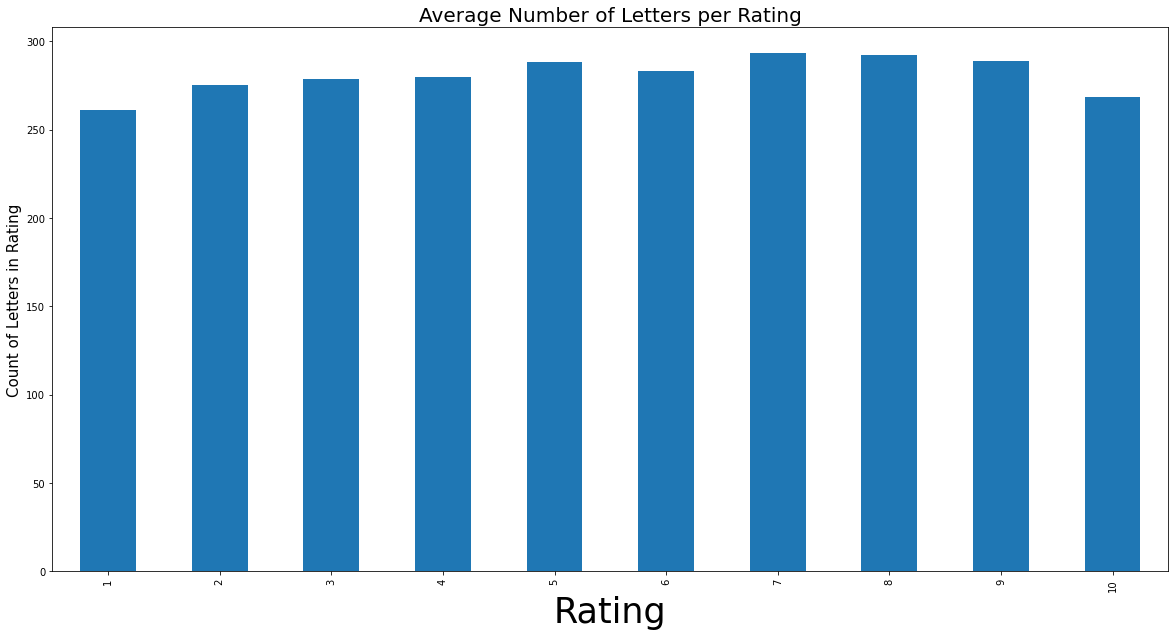

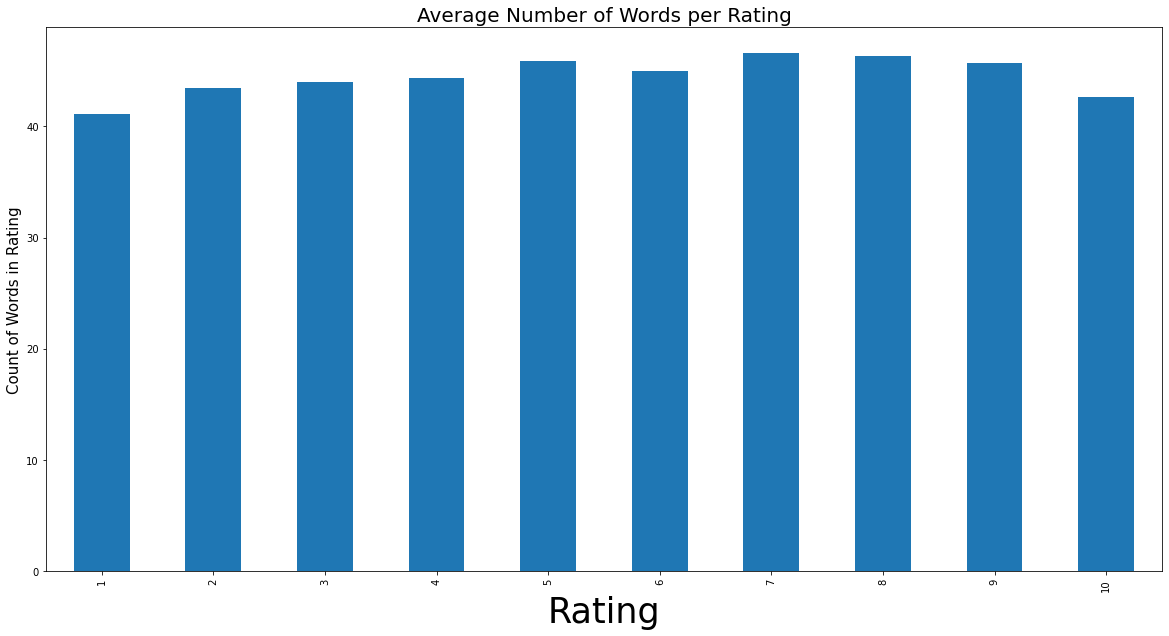

"\n#get all the words in the dataset\ncommonwords = df['Review_Lem']\nwords = []\nfor wordlist in commonwords:\n    words = words + wordlist\n\n#get top 25 words in the dataset\ntop25 = FreqDist(words).most_common(25)\nx, y = zip(*top25)\nplt.figure(figsize=(50,30))\nplt.margins(0.02)\nplt.bar(x, y)\nplt.xlabel('Words', fontsize=50)\nplt.ylabel('Frequency of Words', fontsize=50)\nplt.yticks(fontsize=40)\nplt.xticks(rotation=60, fontsize=40)\nplt.title('25 Most Common Words', fontsize=60)\nplt.show()"

In [5]:
#cleaning the data
def cleaned(text, remove_stopwords = True):  
    
    #remove punctuation. make lowercase 
    text = text.lower()
    text = re.sub(r'https?:\/\/.*[\r\n]*', '', text, flags=re.MULTILINE)
    text = re.sub(r'\<a href', ' ', text)
    text = re.sub(r'&amp;', '', text) 
    text = re.sub(r'[_"\-;%()|+&=*%.,!?:#$@\[\]/]', ' ', text)
    text = re.sub(r'<br />', ' ', text)
    text = re.sub(r'\'', ' ', text)
    
    #remove stopwords
    if remove_stopwords:
        text = text.split()
        stops = set(stopwords.words("english"))
        text = [w for w in text if not w in stops]
        text = " ".join(text)

    # Tokenize each word
    text =  nltk.WordPunctTokenizer().tokenize(text)
    return text

#preprocessed reviews
df['Review_Clean'] = list(map(cleaned, df.Review))

#get lemmatization per reviews
lem = WordNetLemmatizer()
df['Review_Lem'] = df['Review_Clean'].apply(
                    lambda lst:[lem.lemmatize(word) for word in lst])

#get word count per review
df['Review_Count'] = df['Review_Lem'].apply(lambda txt: len(str(txt).split()))

#get number of letters per review
df['Review_Lem_string'] = [' '.join(map(str, h)) for h in df['Review_Lem']]
df['Review_Length'] = df['Review_Lem_string'].astype(str).apply(len)

#visualizing letter per review
letter_avg = df.groupby('Rating')['Review_Length'].mean().plot(kind='bar', figsize=(20,10))
plt.xlabel('Rating', fontsize=15)
plt.ylabel('Count of Letters in Rating', fontsize=15)
plt.xticks(fontsize=10)
plt.yticks(fontsize=10)
plt.title('Average Number of Letters per Rating', fontsize=20)
plt.show()

#visualizing word count in each rating category per review
word_avg = df.groupby('Rating')['Review_Count'].mean().plot(kind='bar', figsize=(20,10))
plt.xlabel('Rating', fontsize=15)
plt.ylabel('Count of Words in Rating', fontsize=15)
plt.xticks(fontsize=10)
plt.yticks(fontsize=10)
plt.title('Average Number of Words per Rating', fontsize=20)
plt.show()

#get all the words in the dataset
commonwords = df['Review_Lem']
words = []
for wordlist in commonwords:
    words = words + wordlist

#get top 25 words in the dataset
top25 = FreqDist(words).most_common(25)
x, y = zip(*top25)
plt.figure(figsize=(20,10))
plt.margins(0.02)
plt.bar(x, y)
plt.xlabel('Words', fontsize=15)
plt.ylabel('Frequency of Words', fontsize=15)
plt.yticks(fontsize=10)
plt.xticks(rotation=10, fontsize=10)
plt.title('25 Most Common Words', fontsize=20)
plt.show()

['039' 'pain' 'taking' 'day' 'took' 'days' 'like' 'months' 'pill' 've']
['039' 'years' 'day' 'pain' 'effects' 've' 'life' 'works' 'taking' 'great']
Raw accuracy score: 0.7787150530229996
************Classification Report Naiive Bayes Model************
               precision    recall  f1-score   support

           1       0.95      0.27      0.42      8652
          10       0.76      0.99      0.86     20392

    accuracy                           0.78     29044
   macro avg       0.86      0.63      0.64     29044
weighted avg       0.82      0.78      0.73     29044



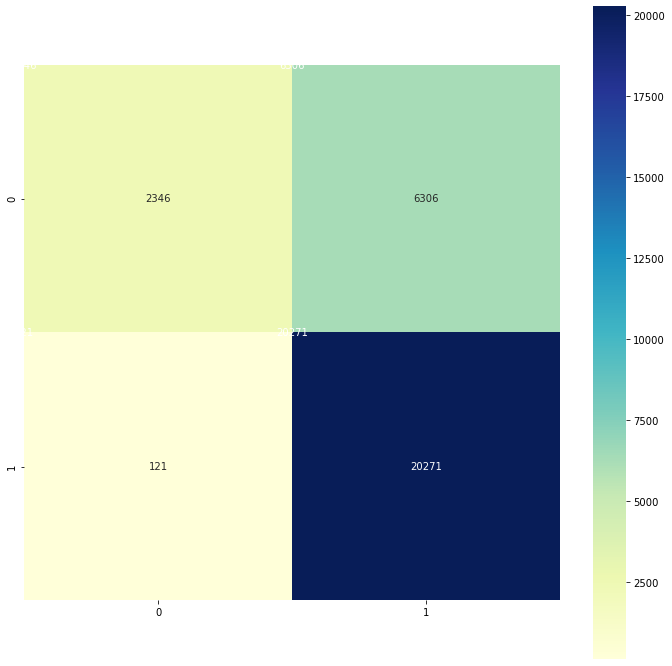

In [3]:
#tf-idf calculations
reviews = drugs_df['Review']
temp = reviews
stop_words = set(stopwords.words('english'))
tfidf_vectorizer = TfidfVectorizer(stop_words='english', lowercase=True)
vector = tfidf_vectorizer.fit_transform(temp)
l = vector.toarray()
vectorizer = tfidf_vectorizer.transform(temp)

#save tf-idf matrix to csv
file = open('tf_idf.csv', 'w+', newline ='') 
with file:     
    write = csv.writer(file) 
    write.writerows(l)

#Naive bayes classifier
classifier = MultinomialNB()
x_train, x_test, y_train, y_test = train_test_split(vectorizer, Y, test_size = 0.4)
classify = MultinomialNB().fit(x_train, y_train)
y_pred = classify.predict(x_test)
score = accuracy_score(y_test, y_pred)

#top 10 words in both the two ratings
toplow_sorted = classify.feature_log_prob_[0, :].argsort()[::-1]
tophigh_sorted = classify.feature_log_prob_[1, :].argsort()[::-1]

print(np.take(tfidf_vectorizer.get_feature_names_out(), toplow_sorted[:10]))
print(np.take(tfidf_vectorizer.get_feature_names_out(), tophigh_sorted[:10]))

print('Raw accuracy score:', score)
print("************Classification Report Naiive Bayes Model************\n", classification_report(y_test, y_pred))

#visualizing the confusion matrix
cmat = confusion_matrix(y_test, y_pred)
fig, x = plt.subplots(figsize=(12, 12))
x.imshow(cmat)
x.grid(False)
x.xaxis.set(ticks=(0, 1), ticklabels=('Predicted 10s', 'Predicted 1s'))
x.yaxis.set(ticks=(0, 1), ticklabels=('Actual 10s', 'Actual 1s'))
x.set_ylim(1.5, -0.5)
sns.heatmap(pd.DataFrame(cmat), annot=True, cmap="YlGnBu" ,fmt='g')
for i in range(2):
    for k in range(2):
        x.text(k, i, cmat[i, k], ha='center', va='center', color='white')
plt.show()

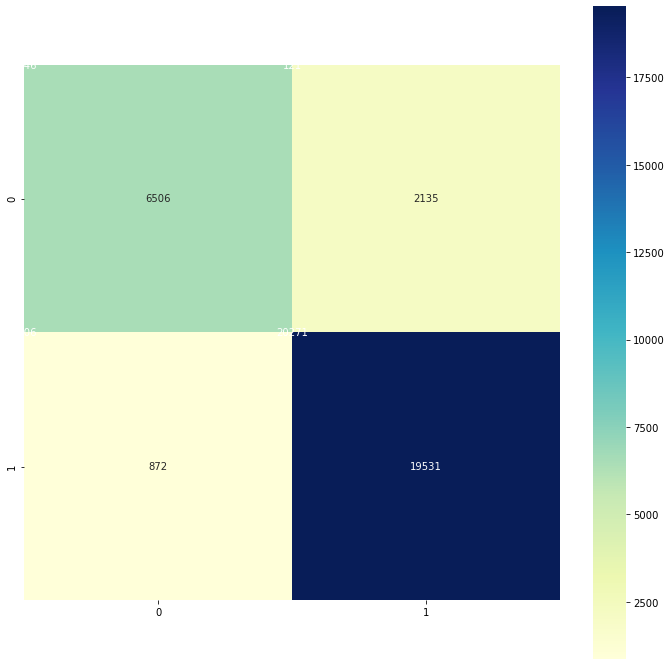

Accuracy: 90.330%, standard dev: 0.276%
Raw accuracy score: 0.8964674287288252
************Classification Report Regression Model************
               precision    recall  f1-score   support

           1       0.88      0.75      0.81      8641
          10       0.90      0.96      0.93     20403

    accuracy                           0.90     29044
   macro avg       0.89      0.86      0.87     29044
weighted avg       0.90      0.90      0.89     29044



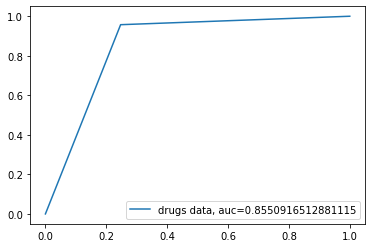

In [4]:
#Logistic Regression
model = LogisticRegression(C=1, class_weight=None, max_iter=1000)
x_tr, x_t, y_tr, y_t = train_test_split(vector, Y, test_size = 0.4)
fitting = model.fit(x_tr, y_tr)
testing = fitting.score(x_t, y_t)
pred = model.predict(x_t)

#cross validation 10 folds
kfold = KFold(n_splits=10, random_state=0, shuffle=True)
scores = cross_val_score(fitting, vector, Y, scoring='accuracy', cv=kfold)

#confusion matrix
cmat_lr = confusion_matrix(y_t, pred)
figure, m = plt.subplots(figsize=(12, 12))
m.imshow(cmat_lr)
m.grid(False)
m.xaxis.set(ticks=(0, 1), ticklabels=('Predicted 10s', 'Predicted 1s'))
m.yaxis.set(ticks=(0, 1), ticklabels=('Actual 10s', 'Actual 1s'))
m.set_ylim(1.5, -0.5)
sns.heatmap(pd.DataFrame(cmat_lr), annot=True, cmap="YlGnBu" ,fmt='g')
for o in range(2):
    for p in range(2):
        m.text(o, p, cmat[o, p], ha='center', va='center', color='white')
plt.show()
print("Accuracy: %.3f%%, standard dev: %.3f%%" % (scores.mean()*100.0, scores.std()*100.0))
print("Raw accuracy score:", testing)
print("************Classification Report Regression Model************\n", classification_report(y_t, pred))

#ROC curve
y_pred_proba = model.predict(x_t)
roc, curve, l = metrics.roc_curve(y_t,  y_pred_proba, pos_label = 10)
rocc = metrics.roc_auc_score(y_t, y_pred_proba)
plt.plot(roc, curve, label="drugs data, auc=" + str(rocc))
plt.legend(loc=4)
plt.show()